In [1]:
# 2022/02/11 업데이트 내용:
# 전용면적 면적 구간별 통계 자료 생성
# 모든 파일에서 계약 최근 개월수가 12개월로 고정되어있던 버그 수정

In [2]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime
tqdm.tqdm.pandas()

In [3]:
target_gu = '은평구' # 구 명
target_dong = '불광' # 동 명: 동 명에서 마지막 글자 '동' 뺄 것
#target_purpose = '준주거' # 종 명: 건드릴 필요 없음
target_building_age = 5 # 건물연식: 건드릴 필요 없음
target_period = 36 # 계약날짜 검색범위: 건드릴 필요 없음
target_starting_year = 2018 # 검색 시작 계약 년도: 건드릴 필요 없음

In [4]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [5]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20220216'

In [6]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [7]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [8]:
def data_prep(bdtype, tradetype, starting_year=2018):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    if (tradetype != '매매') & (tradetype != '전월세'):
        raise ValueError('두번째 변수는 매매 또는 전월세만 입력 가능')
    
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm.tqdm_notebook(enumerate(filenames)):
        splitted_filename = f.split('실거래가_')       
        file_year = int(splitted_filename[-1][:4])
        
        if file_year < starting_year:
            continue
        
        try:
            df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        except:
            try:
                df = pd.read_csv(basedir + f, encoding='utf-8', header=15)
            except:
                df = pd.read_csv(basedir + f, header=15)
        
        if '건물명' in df.columns:
            df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
        elif '단지명' in df.columns:
            df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
            
        if '대지권면적(㎡)' in df.columns:
            df = df.drop(columns=['대지권면적(㎡)'])
                
            
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])
            
        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
    
    if tradetype == '전월세':
        concat_df = concat_df.rename(columns={'전월세구분':'거래구분', '보증금(만원)':'거래금액(만원)'})
        concat_df = concat_df.drop(columns=['월세(만원)'])
        concat_df = concat_df[concat_df['거래구분'] == '전세']
    elif tradetype == '매매':
        concat_df['거래구분'] = '매매'
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].astype('Int64')
    concat_df['계약일'] = concat_df['계약일'].astype('Int64')
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['번지', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [9]:
apart_trade_df = data_prep('아파트', '매매')
apart_lease_df = data_prep('아파트', '전월세')
apart_df = pd.concat([apart_trade_df, apart_lease_df]).reset_index(drop=True)
del apart_trade_df, apart_lease_df
apart_df['부동산유형'] = '아파트'
print(apart_df.shape)
apart_df.head()

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

0it [00:00, ?it/s]

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (10,18) have mixed types.Specify dtype option on import or set low_memory=False.
  


(789651, 23)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형
0,서울특별시 강남구 개포동 658-1,언주로 3,서울특별시 강남구 개포동,658.0,1.0,개포6차우성아파트1동~8동,79.97,130000,4,1987.0,-,-,매매,31.0,2018-01-03,1625.609604,35.0,NaN,NaN,NaN,NaN,NaN,아파트
1,서울특별시 강남구 개포동 658-1,언주로 3,서울특별시 강남구 개포동,658.0,1.0,개포6차우성아파트1동~8동,79.97,117000,2,1987.0,-,-,매매,31.0,2018-01-08,1463.048643,35.0,NaN,NaN,NaN,NaN,NaN,아파트
2,서울특별시 강남구 개포동 658-1,언주로 3,서울특별시 강남구 개포동,658.0,1.0,개포6차우성아파트1동~8동,79.97,130000,1,1987.0,-,-,매매,31.0,2018-01-11,1625.609604,35.0,NaN,NaN,NaN,NaN,NaN,아파트
3,서울특별시 강남구 개포동 658-1,언주로 3,서울특별시 강남구 개포동,658.0,1.0,개포6차우성아파트1동~8동,79.97,139500,2,1987.0,-,-,매매,31.0,2018-03-19,1744.404152,35.0,NaN,NaN,NaN,NaN,NaN,아파트
4,서울특별시 강남구 개포동 658-1,언주로 3,서울특별시 강남구 개포동,658.0,1.0,개포6차우성아파트1동~8동,54.98,107500,5,1987.0,-,-,매매,31.0,2018-04-05,1955.256457,35.0,NaN,NaN,NaN,NaN,NaN,아파트


In [10]:
yunrip_trade_df = data_prep('연립다세대', '매매')
yunrip_lease_df = data_prep('연립다세대', '전월세')
yunrip_df = pd.concat([yunrip_trade_df, yunrip_lease_df]).reset_index(drop=True)
del yunrip_trade_df, yunrip_lease_df
yunrip_df['부동산유형'] = '연립다세대'
print(yunrip_df.shape)
yunrip_df.head()

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

0it [00:00, ?it/s]

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  


(475905, 23)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형
0,서울특별시 강남구 개포동 1172-2,논현로6길 22-6,서울특별시 강남구 개포동,1172,2,(1172-2),29.95,25000,4,2012.0,-,-,매매,6.0,2018-01-13,834.724541,10.0,NaN,NaN,NaN,NaN,NaN,연립다세대
1,서울특별시 강남구 개포동 1216-4,개포로26길 16,서울특별시 강남구 개포동,1216,4,(1216-4),29.12,25300,4,2012.0,-,-,매매,6.0,2018-10-23,868.818681,10.0,NaN,NaN,NaN,NaN,NaN,연립다세대
2,서울특별시 강남구 개포동 1187-8,논현로8길 17,서울특별시 강남구 개포동,1187,8,1187-8,55.96,45500,4,2015.0,-,-,매매,3.0,2018-01-04,813.080772,7.0,NaN,NaN,NaN,NaN,NaN,연립다세대
3,서울특별시 강남구 개포동 1187-8,논현로8길 17,서울특별시 강남구 개포동,1187,8,1187-8,59.84,51000,3,2015.0,-,-,매매,3.0,2018-03-09,852.272727,7.0,NaN,NaN,NaN,NaN,NaN,연립다세대
4,서울특별시 강남구 개포동 1187-8,논현로8길 17,서울특별시 강남구 개포동,1187,8,1187-8,59.84,51000,2,2015.0,-,-,매매,3.0,2018-04-14,852.272727,7.0,NaN,NaN,NaN,NaN,NaN,연립다세대


In [11]:
officetel_trade_df = data_prep('오피스텔', '매매')
officetel_lease_df = data_prep('오피스텔', '전월세')
officetel_df = pd.concat([officetel_trade_df, officetel_lease_df]).reset_index(drop=True)
del officetel_trade_df, officetel_lease_df
officetel_df['부동산유형'] = '오피스텔'
print(officetel_df.shape)
officetel_df.head()

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

0it [00:00, ?it/s]

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  


(155554, 23)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형
0,서울특별시 강남구 개포동 13-3,개포로 623,서울특별시 강남구 개포동,13,3,대청타워,31.91,18500,20,1997.0,-,-,매매,21.0,2018-01-02,579.755563,25.0,NaN,NaN,NaN,NaN,NaN,오피스텔
1,서울특별시 강남구 개포동 13-3,개포로 623,서울특별시 강남구 개포동,13,3,대청타워,31.91,19900,14,1997.0,-,-,매매,21.0,2018-01-04,623.628956,25.0,NaN,NaN,NaN,NaN,NaN,오피스텔
2,서울특별시 강남구 개포동 13-3,개포로 623,서울특별시 강남구 개포동,13,3,대청타워,32.44,20000,26,1997.0,-,-,매매,21.0,2018-01-08,616.522811,25.0,NaN,NaN,NaN,NaN,NaN,오피스텔
3,서울특별시 강남구 개포동 13-3,개포로 623,서울특별시 강남구 개포동,13,3,대청타워,32.44,20000,26,1997.0,-,-,매매,21.0,2018-01-18,616.522811,25.0,NaN,NaN,NaN,NaN,NaN,오피스텔
4,서울특별시 강남구 개포동 13-3,개포로 623,서울특별시 강남구 개포동,13,3,대청타워,32.44,21000,22,1997.0,-,-,매매,21.0,2018-01-20,647.348952,25.0,NaN,NaN,NaN,NaN,NaN,오피스텔


In [12]:
house_df = pd.concat([apart_df, yunrip_df, officetel_df]).sort_values(['시군구', '본번', '부번', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
del apart_df, yunrip_df, officetel_df
print(house_df.shape)
house_df.head()

(1421110, 23)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형
0,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,25000,13,1992.0,NaN,NaN,전세,26.0,2018-01-03,753.465943,30.0,NaN,NaN,NaN,NaN,NaN,아파트
1,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,26000,6,1992.0,NaN,NaN,전세,26.0,2018-01-12,783.604581,30.0,NaN,NaN,NaN,NaN,NaN,아파트
2,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,27000,13,1992.0,NaN,NaN,전세,26.0,2018-01-13,813.743219,30.0,NaN,NaN,NaN,NaN,NaN,아파트
3,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,27000,12,1992.0,NaN,NaN,전세,26.0,2018-01-17,813.743219,30.0,NaN,NaN,NaN,NaN,NaN,아파트
4,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,71000,4,1992.0,-,-,매매,26.0,2018-01-20,2139.843279,30.0,NaN,NaN,NaN,NaN,NaN,아파트


In [13]:
'''land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()'''

"land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')\nprint(land_specs_df.shape)\nland_specs_df.head()"

In [14]:
'''last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()'''

"last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)\nprint(last_df.shape)\nlast_df.head()"

In [15]:
'''house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)'''

"house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)\nprint(house_merge_df.shape)"

In [16]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
#house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
#house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [17]:
house_df['일괄계약'] = 'N'

In [18]:
#house_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)

In [19]:
'''print(house_df.shape)
house_df.head()'''

'print(house_df.shape)\nhouse_df.head()'

In [20]:
def identify_bulk_contract(df):
    df = df.copy()
    
    for addr in tqdm.tqdm_notebook(df['지번주소'].unique()):
        addr_df = df[df['지번주소'] == addr]
        
        for btyear in addr_df['건축년도'].unique():
            btyear_df = addr_df[addr_df['건축년도'] == btyear]
        
            for contract_date in btyear_df['계약날짜'].unique():
                contract_date_df = btyear_df[btyear_df['계약날짜'] == contract_date]

                if contract_date_df.shape[0] >= 5:
                    df.loc[contract_date_df.index, '일괄계약'] = 'Y'
    
    return df

In [21]:
target_1_12_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=6)))
    #&(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_1_12_df.shape)
target_1_12_df.head()

(786, 26)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약
1295080,서울특별시 은평구 불광동 8-35,불광로 98-13,서울특별시 은평구 불광동,8.0,35.0,바른주택(8-35),58.38,14000,3,2003.0,NaN,NaN,전세,18.0,2021-11-25,239.808153,19.0,-,-,-,NaN,NaN,연립다세대,은평구,불광동,N
1295090,서울특별시 은평구 불광동 8-51,불광로6길 11-2,서울특별시 은평구 불광동,8.0,51.0,월드그린,65.22,24000,7,2003.0,NaN,NaN,전세,18.0,2021-10-25,367.985281,19.0,-,-,-,NaN,NaN,아파트,은평구,불광동,N
1295117,서울특별시 은평구 불광동 8-55,불광로6길 15-1,서울특별시 은평구 불광동,8.0,55.0,삼환그린파크(8-55),62.35,25200,1,1995.0,-,-,매매,26.0,2021-09-27,404.170008,27.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N
1295122,서울특별시 은평구 불광동 8-61,불광로6길 15,서울특별시 은평구 불광동,8.0,61.0,삼환그린파크(8-61),53.82,21900,1,1995.0,-,-,매매,26.0,2021-10-19,406.911929,27.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N
1295124,서울특별시 은평구 불광동 8-61,불광로6길 15,서울특별시 은평구 불광동,8.0,61.0,삼환그린파크(8-61),65.34,22000,4,1995.0,NaN,NaN,전세,27.0,2022-01-22,336.700337,27.0,-,-,-,NaN,NaN,연립다세대,은평구,불광동,N


In [22]:
target_2_24_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=12)))
    #&(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_2_24_df.shape)
target_2_24_df.head()

(2112, 26)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약
1295066,서울특별시 은평구 불광동 8-10,불광로8길 7,서울특별시 은평구 불광동,8.0,10.0,(8-10),81.52,17000,2,1979.0,NaN,NaN,전세,42.0,2021-03-27,208.537782,43.0,-,-,-,NaN,NaN,연립다세대,은평구,불광동,N
1295080,서울특별시 은평구 불광동 8-35,불광로 98-13,서울특별시 은평구 불광동,8.0,35.0,바른주택(8-35),58.38,14000,3,2003.0,NaN,NaN,전세,18.0,2021-11-25,239.808153,19.0,-,-,-,NaN,NaN,연립다세대,은평구,불광동,N
1295083,서울특별시 은평구 불광동 8-35,불광로 98-13,서울특별시 은평구 불광동,8.0,35.0,바른주택(8-35),66.69,29000,2,2003.0,-,-,매매,18.0,2021-07-09,434.847803,19.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N
1295086,서울특별시 은평구 불광동 8-37,불광로 98-3,서울특별시 은평구 불광동,8.0,37.0,(8-37),62.92,15000,3,1993.0,NaN,NaN,전세,28.0,2021-03-06,238.397966,29.0,202103~202303,-,-,NaN,NaN,연립다세대,은평구,불광동,N
1295090,서울특별시 은평구 불광동 8-51,불광로6길 11-2,서울특별시 은평구 불광동,8.0,51.0,월드그린,65.22,24000,7,2003.0,NaN,NaN,전세,18.0,2021-10-25,367.985281,19.0,-,-,-,NaN,NaN,아파트,은평구,불광동,N


In [23]:
target_3_36_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=24)))
    #&(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_3_36_df.shape)
target_3_36_df.head()

(5235, 26)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약
1295062,서울특별시 은평구 불광동 8-7,불광로 104-2,서울특별시 은평구 불광동,8.0,7.0,한양빌라(8-7),35.94,16000,2,1991.0,-,-,매매,29.0,2020-08-25,445.186422,31.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N
1295066,서울특별시 은평구 불광동 8-10,불광로8길 7,서울특별시 은평구 불광동,8.0,10.0,(8-10),81.52,17000,2,1979.0,NaN,NaN,전세,42.0,2021-03-27,208.537782,43.0,-,-,-,NaN,NaN,연립다세대,은평구,불광동,N
1295067,서울특별시 은평구 불광동 8-18,불광로8길 19-1,서울특별시 은평구 불광동,8.0,18.0,봉상아트빌라C동,35.03,15900,1,1990.0,-,-,매매,30.0,2020-06-05,453.896660,32.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N
1295071,서울특별시 은평구 불광동 8-19,불광로8길 16,서울특별시 은평구 불광동,8.0,19.0,제일빌라(8-19),37.03,14100,2,1995.0,-,-,매매,25.0,2020-05-04,380.772347,27.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N
1295072,서울특별시 은평구 불광동 8-19,불광로8길 16,서울특별시 은평구 불광동,8.0,19.0,제일빌라(8-19),37.03,9000,1,1995.0,NaN,NaN,전세,25.0,2020-11-10,243.046179,27.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N


In [24]:
target_5_60_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=36)))
    #&(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_5_60_df.shape)
target_5_60_df.head()

(8016, 26)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약
1295062,서울특별시 은평구 불광동 8-7,불광로 104-2,서울특별시 은평구 불광동,8.0,7.0,한양빌라(8-7),35.94,16000,2,1991.0,-,-,매매,29.0,2020-08-25,445.186422,31.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N
1295065,서울특별시 은평구 불광동 8-7,불광로 104-2,서울특별시 은평구 불광동,8.0,7.0,한양빌라(8-7),38.07,14000,2,1991.0,-,-,매매,28.0,2019-08-28,367.743630,31.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N
1295066,서울특별시 은평구 불광동 8-10,불광로8길 7,서울특별시 은평구 불광동,8.0,10.0,(8-10),81.52,17000,2,1979.0,NaN,NaN,전세,42.0,2021-03-27,208.537782,43.0,-,-,-,NaN,NaN,연립다세대,은평구,불광동,N
1295067,서울특별시 은평구 불광동 8-18,불광로8길 19-1,서울특별시 은평구 불광동,8.0,18.0,봉상아트빌라C동,35.03,15900,1,1990.0,-,-,매매,30.0,2020-06-05,453.896660,32.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N
1295068,서울특별시 은평구 불광동 8-18,불광로8길 19-1,서울특별시 은평구 불광동,8.0,18.0,봉상아트빌라C동,40.14,15700,1,1990.0,-,-,매매,29.0,2019-09-24,391.131041,32.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N


In [25]:
target_1_12_df = identify_bulk_contract(target_1_12_df)
print(target_1_12_df.shape)

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/334 [00:00<?, ?it/s]

(786, 26)


In [26]:
target_2_24_df = identify_bulk_contract(target_2_24_df)
print(target_2_24_df.shape)

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/651 [00:00<?, ?it/s]

(2112, 26)


In [27]:
target_3_36_df = identify_bulk_contract(target_3_36_df)
print(target_3_36_df.shape)

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/1015 [00:00<?, ?it/s]

(5235, 26)


In [28]:
target_5_60_df = identify_bulk_contract(target_5_60_df)
print(target_5_60_df.shape)

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/1140 [00:00<?, ?it/s]

(8016, 26)


In [29]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [30]:
print(sales_idx_df.shape)
sales_idx_df.head()

(1, 381)


,지 역,2006년 01월_지수,2006년 01월_변동률,2006년 02월_지수,2006년 02월_변동률,2006년 03월_지수,2006년 03월_변동률,2006년 04월_지수,2006년 04월_변동률,2006년 05월_지수,2006년 05월_변동률,2006년 06월_지수,2006년 06월_변동률,2006년 07월_지수,2006년 07월_변동률,2006년 08월_지수,2006년 08월_변동률,2006년 09월_지수,2006년 09월_변동률,2006년 10월_지수,2006년 10월_변동률,2006년 11월_지수,2006년 11월_변동률,2006년 12월_지수,2006년 12월_변동률,2007년 01월_지수,2007년 01월_변동률,2007년 02월_지수,2007년 02월_변동률,2007년 03월_지수,2007년 03월_변동률,2007년 04월_지수,2007년 04월_변동률,2007년 05월_지수,2007년 05월_변동률,2007년 06월_지수,2007년 06월_변동률,2007년 07월_지수,2007년 07월_변동률,2007년 08월_지수,2007년 08월_변동률,2007년 09월_지수,2007년 09월_변동률,2007년 10월_지수,2007년 10월_변동률,2007년 11월_지수,2007년 11월_변동률,2007년 12월_지수,2007년 12월_변동률,2008년 01월_지수,2008년 01월_변동률,2008년 02월_지수,2008년 02월_변동률,2008년 03월_지수,2008년 03월_변동률,2008년 04월_지수,2008년 04월_변동률,2008년 05월_지수,2008년 05월_변동률,2008년 06월_지수,2008년 06월_변동률,2008년 07월_지수,2008년 07월_변동률,2008년 08월_지수,2008년 08월_변동률,2008년 09월_지수,2008년 09월_변동률,2008년 10월_지수,2008년 10월_변동률,2008년 11월_지수,2008년 11월_변동률,2008년 12월_지수,2008년 12월_변동률,2009년 01월_지수,2009년 01월_변동률,2009년 02월_지수,2009년 02월_변동률,2009년 03월_지수,2009년 03월_변동률,2009년 04월_지수,2009년 04월_변동률,2009년 05월_지수,2009년 05월_변동률,2009년 06월_지수,2009년 06월_변동률,2009년 07월_지수,2009년 07월_변동률,2009년 08월_지수,2009년 08월_변동률,2009년 09월_지수,2009년 09월_변동률,2009년 10월_지수,2009년 10월_변동률,2009년 11월_지수,2009년 11월_변동률,2009년 12월_지수,2009년 12월_변동률,2010년 01월_지수,2010년 01월_변동률,2010년 02월_지수,2010년 02월_변동률,2010년 03월_지수,2010년 03월_변동률,2010년 04월_지수,2010년 04월_변동률,2010년 05월_지수,2010년 05월_변동률,2010년 06월_지수,2010년 06월_변동률,2010년 07월_지수,2010년 07월_변동률,2010년 08월_지수,2010년 08월_변동률,2010년 09월_지수,2010년 09월_변동률,2010년 10월_지수,2010년 10월_변동률,2010년 11월_지수,2010년 11월_변동률,2010년 12월_지수,2010년 12월_변동률,2011년 01월_지수,2011년 01월_변동률,2011년 02월_지수,2011년 02월_변동률,2011년 03월_지수,2011년 03월_변동률,2011년 04월_지수,2011년 04월_변동률,2011년 05월_지수,2011년 05월_변동률,2011년 06월_지수,2011년 06월_변동률,2011년 07월_지수,2011년 07월_변동률,2011년 08월_지수,2011년 08월_변동률,2011년 09월_지수,2011년 09월_변동률,2011년 10월_지수,2011년 10월_변동률,2011년 11월_지수,2011년 11월_변동률,2011년 12월_지수,2011년 12월_변동률,2012년 01월_지수,2012년 01월_변동률,2012년 02월_지수,2012년 02월_변동률,2012년 03월_지수,2012년 03월_변동률,2012년 04월_지수,2012년 04월_변동률,2012년 05월_지수,2012년 05월_변동률,2012년 06월_지수,2012년 06월_변동률,2012년 07월_지수,2012년 07월_변동률,2012년 08월_지수,2012년 08월_변동률,2012년 09월_지수,2012년 09월_변동률,2012년 10월_지수,2012년 10월_변동률,2012년 11월_지수,2012년 11월_변동률,2012년 12월_지수,2012년 12월_변동률,2013년 01월_지수,2013년 01월_변동률,2013년 02월_지수,2013년 02월_변동률,2013년 03월_지수,2013년 03월_변동률,2013년 04월_지수,2013년 04월_변동률,2013년 05월_지수,2013년 05월_변동률,2013년 06월_지수,2013년 06월_변동률,2013년 07월_지수,2013년 07월_변동률,2013년 08월_지수,2013년 08월_변동률,2013년 09월_지수,2013년 09월_변동률,2013년 10월_지수,2013년 10월_변동률,2013년 11월_지수,2013년 11월_변동률,2013년 12월_지수,2013년 12월_변동률,2014년 01월_지수,2014년 01월_변동률,2014년 02월_지수,2014년 02월_변동률,2014년 03월_지수,2014년 03월_변동률,2014년 04월_지수,2014년 04월_변동률,2014년 05월_지수,2014년 05월_변동률,2014년 06월_지수,2014년 06월_변동률,2014년 07월_지수,2014년 07월_변동률,2014년 08월_지수,2014년 08월_변동률,2014년 09월_지수,2014년 09월_변동률,2014년 10월_지수,2014년 10월_변동률,2014년 11월_지수,2014년 11월_변동률,2014년 12월_지수,2014년 12월_변동률,2015년 01월_지수,2015년 01월_변동률,2015년 02월_지수,2015년 02월_변동률,2015년 03월_지수,2015년 03월_변동률,2015년 04월_지수,2015년 04월_변동률,2015년 05월_지수,2015년 05월_변동률,2015년 06월_지수,2015년 06월_변동률,2015년 07월_지수,2015년 07월_변동률,2015년 08월_지수,2015년 08월_변동률,2015년 09월_지수,2015년 09월_변동률,2015년 10월_지수,2015년 10월_변동률,2015년 11월_지수,2015년 11월_변동률,2015년 12월_지수,2015년 12월_변동률,2016년 01월_지수,2016년 01월_변동률,2016년 02월_지수,2016년 02월_변동률,2016년 03월_지수,2016년 03월_변동률,2016년 04월_지수,2016년 04월_변동률,2016년 05월_지수,2016년 05월_변동률,2016년 06월_지수,2016년 06월_변동률,2016년 07월_지수,2016년 07월_변동률,2016년 08월_지수,2016년 08월_변동률,2016년 09월_지수,2016년 09월_변동률,2016년 10월_지수,2016년 10월_변동률,2016년 11월_지수,2016년 11월_변동률,2016년 12월_지수,2016년 12월_변동률,2017년 01월_지수,2017년 01월_변동률,2017년 02월_지수,2017년 02월_변동률,2017년 03월_지수,2017년 03월_변동률,2017년 04월_지수,2017년 04월_변동률,2017년 05월_지수,2017년 05월_변동률,2017년 06월_지수,2017년 06월_변동률,2017년 07월_지수,2017년 07월_변동률,2017년 08월_지수,2017년 08월_변동률,2017년 09월_지수,2017년 09월_변동률,2017년 10월_지수,2017년 10월_변동률,2017년 11월_지수,2017년 11월_변동률,2017년 12월_지수,2017년 12월_변동률,2018년 01월_지수,2018년 01월_변동률,2018년 02월_지수,2018년 02월_변동률,2018년 03월_지수,2018년 03월_변동률,2018년 04월_지수,2018년 04월_변동률

In [31]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        try:
            idx = df[year+'년 '+month+'월_지수'].iloc[0]
            return idx
        
        except:
            return '지수없음'

In [32]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    df['계약날짜_실거래지수'] = df['계약날짜'].apply(get_sales_idx)
    
    df_idx_positive = df[df['계약날짜_실거래지수'] != '지수없음']
    
    df['지수적용단가'] = df['단가(만원/㎡)']
    
    df_idx_positive['지수적용단가'] = df_idx_positive['단가(만원/㎡)'] / df_idx_positive['계약날짜_실거래지수'] * last_idx
    
    df.loc[df_idx_positive.index, '지수적용단가'] = df_idx_positive['지수적용단가']
    
    df['지수적용단가'] = df['지수적용단가'].astype('float')
    
    df['지수적용날짜'] = '지수없음'
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    df.loc[df_idx_positive.index, '지수적용날짜'] = last_date
    
    return df

In [33]:
target_1_12_df = get_index_applied_prices(target_1_12_df)
print(target_1_12_df.shape)
target_1_12_df.head()

(786, 29)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜
1295080,서울특별시 은평구 불광동 8-35,불광로 98-13,서울특별시 은평구 불광동,8.0,35.0,바른주택(8-35),58.38,14000,3,2003.0,NaN,NaN,전세,18.0,2021-11-25,239.808153,19.0,-,-,-,NaN,NaN,연립다세대,은평구,불광동,N,지수없음,239.808153,지수없음
1295090,서울특별시 은평구 불광동 8-51,불광로6길 11-2,서울특별시 은평구 불광동,8.0,51.0,월드그린,65.22,24000,7,2003.0,NaN,NaN,전세,18.0,2021-10-25,367.985281,19.0,-,-,-,NaN,NaN,아파트,은평구,불광동,N,137.186,367.985281,2021년 10월
1295117,서울특별시 은평구 불광동 8-55,불광로6길 15-1,서울특별시 은평구 불광동,8.0,55.0,삼환그린파크(8-55),62.35,25200,1,1995.0,-,-,매매,26.0,2021-09-27,404.170008,27.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N,135.189,410.140372,2021년 10월
1295122,서울특별시 은평구 불광동 8-61,불광로6길 15,서울특별시 은평구 불광동,8.0,61.0,삼환그린파크(8-61),53.82,21900,1,1995.0,-,-,매매,26.0,2021-10-19,406.911929,27.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N,137.186,406.911929,2021년 10월
1295124,서울특별시 은평구 불광동 8-61,불광로6길 15,서울특별시 은평구 불광동,8.0,61.0,삼환그린파크(8-61),65.34,22000,4,1995.0,NaN,NaN,전세,27.0,2022-01-22,336.700337,27.0,-,-,-,NaN,NaN,연립다세대,은평구,불광동,N,지수없음,336.700337,지수없음


In [34]:
target_2_24_df = get_index_applied_prices(target_2_24_df)
print(target_2_24_df.shape)
target_2_24_df.head()

(2112, 29)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜
1295066,서울특별시 은평구 불광동 8-10,불광로8길 7,서울특별시 은평구 불광동,8.0,10.0,(8-10),81.52,17000,2,1979.0,NaN,NaN,전세,42.0,2021-03-27,208.537782,43.0,-,-,-,NaN,NaN,연립다세대,은평구,불광동,N,123.851,230.990983,2021년 10월
1295080,서울특별시 은평구 불광동 8-35,불광로 98-13,서울특별시 은평구 불광동,8.0,35.0,바른주택(8-35),58.38,14000,3,2003.0,NaN,NaN,전세,18.0,2021-11-25,239.808153,19.0,-,-,-,NaN,NaN,연립다세대,은평구,불광동,N,지수없음,239.808153,지수없음
1295083,서울특별시 은평구 불광동 8-35,불광로 98-13,서울특별시 은평구 불광동,8.0,35.0,바른주택(8-35),66.69,29000,2,2003.0,-,-,매매,18.0,2021-07-09,434.847803,19.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N,131.58,453.374607,2021년 10월
1295086,서울특별시 은평구 불광동 8-37,불광로 98-3,서울특별시 은평구 불광동,8.0,37.0,(8-37),62.92,15000,3,1993.0,NaN,NaN,전세,28.0,2021-03-06,238.397966,29.0,202103~202303,-,-,NaN,NaN,연립다세대,은평구,불광동,N,123.851,264.066203,2021년 10월
1295090,서울특별시 은평구 불광동 8-51,불광로6길 11-2,서울특별시 은평구 불광동,8.0,51.0,월드그린,65.22,24000,7,2003.0,NaN,NaN,전세,18.0,2021-10-25,367.985281,19.0,-,-,-,NaN,NaN,아파트,은평구,불광동,N,137.186,367.985281,2021년 10월


In [35]:
target_3_36_df = get_index_applied_prices(target_3_36_df)
print(target_3_36_df.shape)
target_3_36_df.head()

(5235, 29)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜
1295062,서울특별시 은평구 불광동 8-7,불광로 104-2,서울특별시 은평구 불광동,8.0,7.0,한양빌라(8-7),35.94,16000,2,1991.0,-,-,매매,29.0,2020-08-25,445.186422,31.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N,116.075,526.154163,2021년 10월
1295066,서울특별시 은평구 불광동 8-10,불광로8길 7,서울특별시 은평구 불광동,8.0,10.0,(8-10),81.52,17000,2,1979.0,NaN,NaN,전세,42.0,2021-03-27,208.537782,43.0,-,-,-,NaN,NaN,연립다세대,은평구,불광동,N,123.851,230.990983,2021년 10월
1295067,서울특별시 은평구 불광동 8-18,불광로8길 19-1,서울특별시 은평구 불광동,8.0,18.0,봉상아트빌라C동,35.03,15900,1,1990.0,-,-,매매,30.0,2020-06-05,453.896660,32.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N,114.593,543.386308,2021년 10월
1295071,서울특별시 은평구 불광동 8-19,불광로8길 16,서울특별시 은평구 불광동,8.0,19.0,제일빌라(8-19),37.03,14100,2,1995.0,-,-,매매,25.0,2020-05-04,380.772347,27.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N,111.732,467.517230,2021년 10월
1295072,서울특별시 은평구 불광동 8-19,불광로8길 16,서울특별시 은평구 불광동,8.0,19.0,제일빌라(8-19),37.03,9000,1,1995.0,NaN,NaN,전세,25.0,2020-11-10,243.046179,27.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N,120.598,276.476667,2021년 10월


In [36]:
target_5_60_df = get_index_applied_prices(target_5_60_df)
print(target_5_60_df.shape)
target_5_60_df.head()

(8016, 29)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜
1295062,서울특별시 은평구 불광동 8-7,불광로 104-2,서울특별시 은평구 불광동,8.0,7.0,한양빌라(8-7),35.94,16000,2,1991.0,-,-,매매,29.0,2020-08-25,445.186422,31.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N,116.075,526.154163,2021년 10월
1295065,서울특별시 은평구 불광동 8-7,불광로 104-2,서울특별시 은평구 불광동,8.0,7.0,한양빌라(8-7),38.07,14000,2,1991.0,-,-,매매,28.0,2019-08-28,367.743630,31.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N,107.485,469.361098,2021년 10월
1295066,서울특별시 은평구 불광동 8-10,불광로8길 7,서울특별시 은평구 불광동,8.0,10.0,(8-10),81.52,17000,2,1979.0,NaN,NaN,전세,42.0,2021-03-27,208.537782,43.0,-,-,-,NaN,NaN,연립다세대,은평구,불광동,N,123.851,230.990983,2021년 10월
1295067,서울특별시 은평구 불광동 8-18,불광로8길 19-1,서울특별시 은평구 불광동,8.0,18.0,봉상아트빌라C동,35.03,15900,1,1990.0,-,-,매매,30.0,2020-06-05,453.896660,32.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N,114.593,543.386308,2021년 10월
1295068,서울특별시 은평구 불광동 8-18,불광로8길 19-1,서울특별시 은평구 불광동,8.0,18.0,봉상아트빌라C동,40.14,15700,1,1990.0,-,-,매매,29.0,2019-09-24,391.131041,32.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N,107.866,497.447787,2021년 10월


In [37]:
cols_to_include = [
    '지번주소', '건물(단지)명', '건물연식', '층', '거래구분', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)',
    '부동산유형', '일괄계약', '지수적용날짜', '지수적용단가'
]

In [38]:
try:
    os.makedirs('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/'.format(target_gu, target_dong, date_today_record))
except:
    pass

In [39]:
target_1_12_df = target_1_12_df.sort_values(['시군구', '본번', '부번', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_1_12_df1 = target_1_12_df[cols_to_include]
target_1_12_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식없음_계약최근6개월.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [40]:
target_1_12_30_df1 = target_1_12_df1[target_1_12_df1['전용면적(㎡)'] <= 30]
target_1_12_30_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근6개월_30제곱미터미만.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [41]:
target_1_12_bdyr2_df1 = target_1_12_df1[target_1_12_df1['건물연식'] <= 2]
target_1_12_bdyr2_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근6개월.xlsx'.format(target_gu, target_dong, date_today_record, 2), index=False)

In [42]:
target_1_12_bdyr5_df1 = target_1_12_df1[target_1_12_df1['건물연식'] <= 5]
target_1_12_bdyr5_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근6개월.xlsx'.format(target_gu, target_dong, date_today_record, 5), index=False)

In [43]:
target_2_24_df = target_2_24_df.sort_values(['시군구', '본번', '부번', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_2_24_df1 = target_2_24_df[cols_to_include]
target_2_24_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식없음년_계약최근12개월.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [44]:
target_2_24_30_df1 = target_2_24_df1[target_2_24_df1['전용면적(㎡)'] <= 30]
target_2_24_30_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근12개월_30제곱미터미만.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [45]:
target_2_24_bdyr2_df1 = target_2_24_df1[target_2_24_df1['건물연식'] <= 2]
target_2_24_bdyr2_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근12개월.xlsx'.format(target_gu, target_dong, date_today_record, 2), index=False)

In [46]:
target_2_24_bdyr5_df1 = target_2_24_df1[target_2_24_df1['건물연식'] <= 5]
target_2_24_bdyr5_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근12개월.xlsx'.format(target_gu, target_dong, date_today_record, 5), index=False)

In [47]:
target_3_36_df = target_3_36_df.sort_values(['시군구', '본번', '부번', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_3_36_df1 = target_3_36_df[cols_to_include]
target_3_36_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식없음_계약최근24개월.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [48]:
target_3_36_30_df1 = target_3_36_df1[target_3_36_df1['전용면적(㎡)'] <= 30]
target_3_36_30_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근24개월_30제곱미터미만.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [49]:
target_3_36_bdyr2_df1 = target_3_36_df1[target_3_36_df1['건물연식'] <= 2]
target_3_36_bdyr2_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근24개월.xlsx'.format(target_gu, target_dong, date_today_record, 2), index=False)

In [50]:
target_3_36_bdyr5_df1 = target_3_36_df1[target_3_36_df1['건물연식'] <= 5]
target_3_36_bdyr5_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근24개월.xlsx'.format(target_gu, target_dong, date_today_record, 5), index=False)

In [51]:
target_5_60_df = target_5_60_df.sort_values(['시군구', '본번', '부번', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_5_60_df1 = target_5_60_df[cols_to_include]
target_5_60_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식없음_계약최근36개월.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [52]:
target_5_60_30_df1 = target_5_60_df1[target_5_60_df1['전용면적(㎡)'] <= 30]
target_5_60_30_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근36개월_30제곱미터미만.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [53]:
target_5_60_bdyr2_df1 = target_5_60_df1[target_5_60_df1['건물연식'] <= 2]
target_5_60_bdyr2_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근36개월.xlsx'.format(target_gu, target_dong, date_today_record, 2), index=False)

In [54]:
target_5_60_bdyr5_df1 = target_5_60_df1[target_5_60_df1['건물연식'] <= 5]
target_5_60_bdyr5_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근36개월.xlsx'.format(target_gu, target_dong, date_today_record, 5), index=False)

In [55]:
print(target_2_24_bdyr2_df1.shape)
target_2_24_bdyr2_df1.head()

(220, 13)


,지번주소,건물(단지)명,건물연식,층,거래구분,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),부동산유형,일괄계약,지수적용날짜,지수적용단가
17,서울특별시 은평구 불광동 8-63,REALPARK3차,1.0,5,전세,25.52,2021-12-03,23500,920.846395,연립다세대,N,지수없음,920.846395
18,서울특별시 은평구 불광동 8-63,REALPARK3차,1.0,4,전세,25.43,2021-12-10,22000,865.119937,연립다세대,N,지수없음,865.119937
19,서울특별시 은평구 불광동 8-63,REALPARK3차,1.0,5,전세,25.43,2021-12-11,22000,865.119937,연립다세대,N,지수없음,865.119937
20,서울특별시 은평구 불광동 8-63,REALPARK3차,1.0,5,전세,28.49,2021-12-14,22500,789.750790,연립다세대,N,지수없음,789.750790
21,서울특별시 은평구 불광동 8-63,REALPARK3차,1.0,3,전세,25.43,2021-12-16,20000,786.472670,연립다세대,N,지수없음,786.472670


In [56]:
def create_price_range_statistics_df(tradetype='매매', real_estate_type='연립다세대'):
    range_statistics_df = pd.DataFrame()
    range_statistics_df['전용면적구간'] = np.nan
    range_statistics_df['거래대상수'] = np.nan
    range_statistics_df['평균거래단가(만원/㎡)'] = np.nan
    
    for i, v in tqdm.tqdm_notebook(enumerate(range(17, 40))):
        range_min = v
        range_max = v + 1

        range_statistics_df.loc[i, '전용면적구간'] = '{}이상 {}미만'.format(range_min, range_max)

        range_df = target_2_24_bdyr2_df1[
            (target_2_24_bdyr2_df1['전용면적(㎡)'] >= range_min)
            &(target_2_24_bdyr2_df1['전용면적(㎡)'] < range_max)
            &(target_2_24_bdyr2_df1['거래구분'] == tradetype)
            &(target_2_24_bdyr2_df1['부동산유형'] == real_estate_type)
        ]

        range_statistics_df.loc[i, '거래대상수'] = range_df.shape[0]
        range_statistics_df.loc[i, '평균거래단가(만원/㎡)'] = range_df['단가(만원/㎡)'].mean()
        
    for i, v in tqdm.tqdm_notebook(enumerate(range(40, 65, 5))):
        range_min = v
        range_max = v + 5

        i = i+23

        range_statistics_df.loc[i, '전용면적구간'] = '{}이상 {}미만'.format(range_min, range_max)

        range_df = target_2_24_bdyr2_df1[
            (target_2_24_bdyr2_df1['전용면적(㎡)'] >= range_min)
            &(target_2_24_bdyr2_df1['전용면적(㎡)'] < range_max)
            &(target_2_24_bdyr2_df1['거래구분'] == tradetype)
            &(target_2_24_bdyr2_df1['부동산유형'] == real_estate_type)
        ]

        range_statistics_df.loc[i, '거래대상수'] = range_df.shape[0]
        range_statistics_df.loc[i, '평균거래단가(만원/㎡)'] = range_df['단가(만원/㎡)'].mean()
        
    range_statistics_df.loc[28, '전용면적구간'] = '{}이상 {}미만'.format(65, 100)

    range_df = target_2_24_bdyr2_df1[
        (target_2_24_bdyr2_df1['전용면적(㎡)'] >= 65)
        &(target_2_24_bdyr2_df1['전용면적(㎡)'] < 100)
        &(target_2_24_bdyr2_df1['거래구분'] == tradetype)
        &(target_2_24_bdyr2_df1['부동산유형'] == real_estate_type)
    ]

    range_statistics_df.loc[28, '거래대상수'] = range_df.shape[0]
    range_statistics_df.loc[28, '평균거래단가(만원/㎡)'] = range_df['단가(만원/㎡)'].mean()
    
    return range_statistics_df

In [57]:
range_statistics_df = create_price_range_statistics_df()

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


0it [00:00, ?it/s]

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [58]:
print(range_statistics_df.shape)
range_statistics_df.head()

(29, 3)


,전용면적구간,거래대상수,평균거래단가(만원/㎡)
0,17이상 18미만,0.0,NaN
1,18이상 19미만,0.0,NaN
2,19이상 20미만,0.0,NaN
3,20이상 21미만,0.0,NaN
4,21이상 22미만,0.0,NaN


In [59]:
range_statistics_jeonse_df = create_price_range_statistics_df(tradetype='전세')

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


0it [00:00, ?it/s]

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [60]:
print(range_statistics_jeonse_df.shape)
range_statistics_jeonse_df.head()

(29, 3)


,전용면적구간,거래대상수,평균거래단가(만원/㎡)
0,17이상 18미만,1.0,962.082626
1,18이상 19미만,1.0,1024.258760
2,19이상 20미만,0.0,NaN
3,20이상 21미만,1.0,939.199209
4,21이상 22미만,2.0,780.189578


In [61]:
range_statistics_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전용면적구간별통계자료_연립다세대_매매_실거래가_건물연식{}년_계약최근12개월.xlsx'.format(target_gu, target_dong, date_today_record, 3), index=False)

In [62]:
range_statistics_jeonse_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전용면적구간별통계자료_연립다세대_전세_실거래가_건물연식{}년_계약최근12개월.xlsx'.format(target_gu, target_dong, date_today_record, 3), index=False)

In [63]:
range_statistics_df['거래유형'] = '매매'
range_statistics_jeonse_df['거래유형'] = '전세'

In [64]:
concat_df = pd.concat([range_statistics_df, range_statistics_jeonse_df]).sort_values(['전용면적구간', '거래유형']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(58, 4)


,전용면적구간,거래대상수,평균거래단가(만원/㎡),거래유형
0,17이상 18미만,0.0,NaN,매매
1,17이상 18미만,1.0,962.082626,전세
2,18이상 19미만,0.0,NaN,매매
3,18이상 19미만,1.0,1024.258760,전세
4,19이상 20미만,0.0,NaN,매매


c:\users\max6296\ml\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\max6296\ml\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


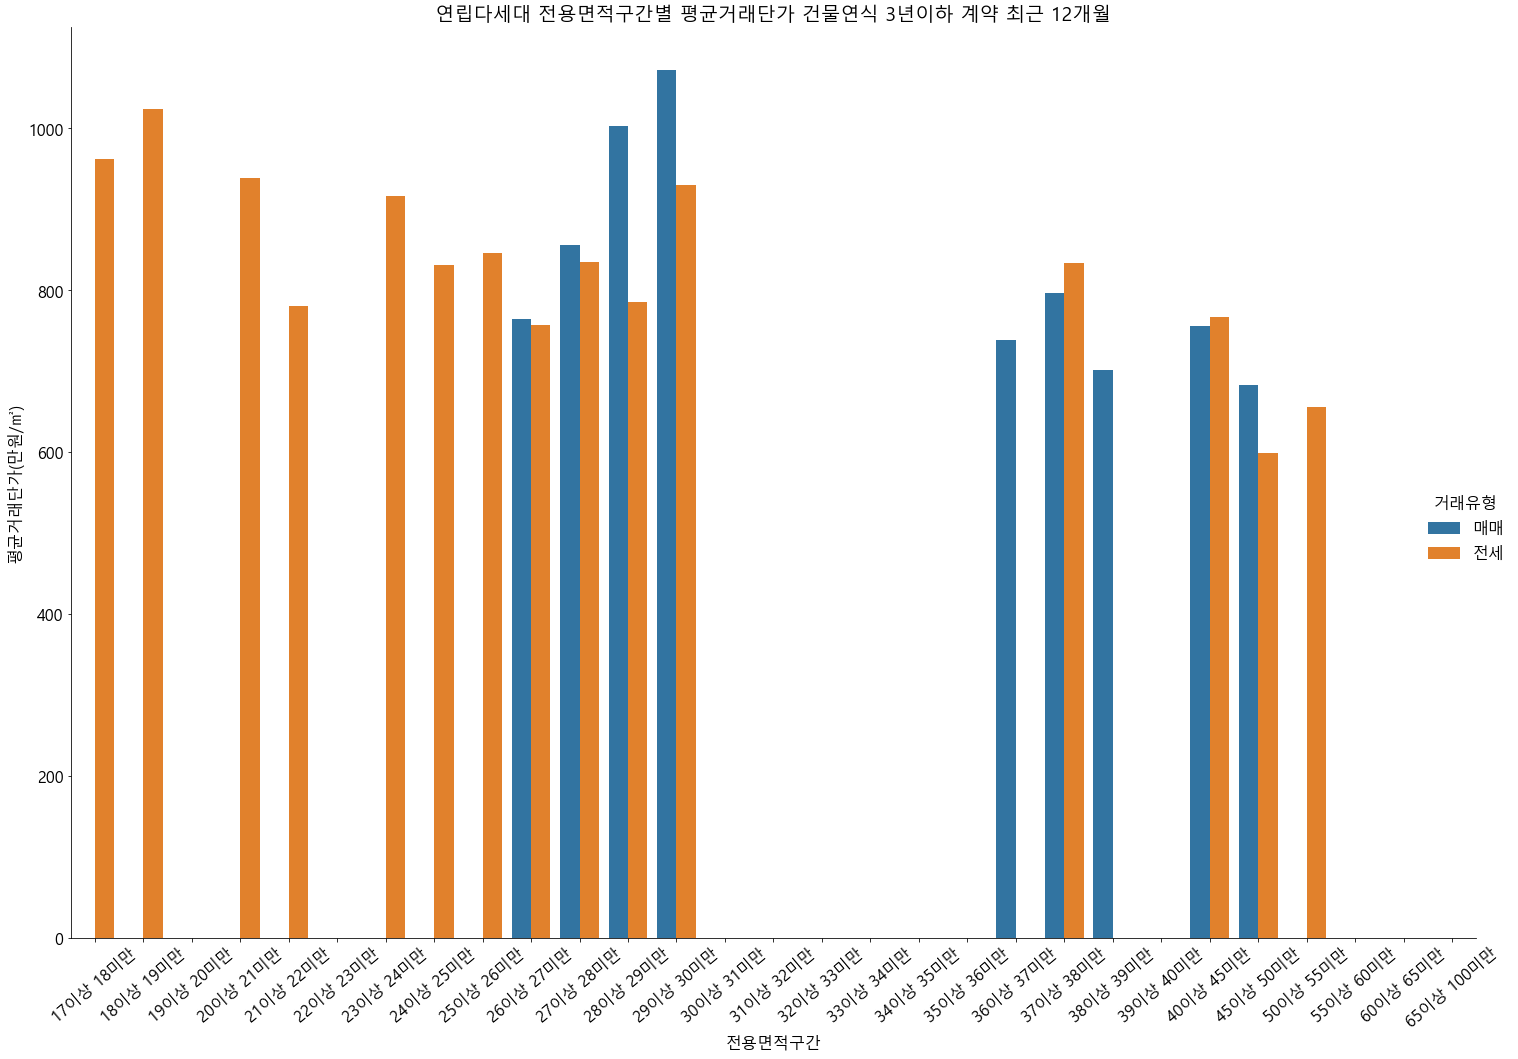

In [65]:
font = {'size': 16}
matplotlib.rc('font', **font)
sns.factorplot(x='전용면적구간', y='평균거래단가(만원/㎡)', hue='거래유형', data=concat_df, kind='bar', size=15, aspect=4/3)
plt.xticks(rotation=40)
plt.title('연립다세대 전용면적구간별 평균거래단가 건물연식 3년이하 계약 최근 12개월')
plt.tight_layout()
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전용면적구간별_연립다세대_평균거래단가_건물연식3년_계약최근12개월.png'.format(target_gu, target_dong, date_today_record))

In [66]:
officetel_range_statistics_df = create_price_range_statistics_df(real_estate_type='오피스텔')
officetel_jeonse_range_statistics_df = create_price_range_statistics_df(tradetype='전세', real_estate_type='오피스텔')

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


0it [00:00, ?it/s]

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [67]:
officetel_range_statistics_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전용면적구간별통계자료_오피스텔_매매_실거래가_건물연식{}년_계약최근12개월.xlsx'.format(target_gu, target_dong, date_today_record, 3), index=False)

In [68]:
officetel_jeonse_range_statistics_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전용면적구간별통계자료_오피스텔_전세_실거래가_건물연식{}년_계약최근12개월.xlsx'.format(target_gu, target_dong, date_today_record, 3), index=False)

In [69]:
officetel_range_statistics_df['거래유형'] = '매매'
officetel_jeonse_range_statistics_df['거래유형'] = '전세'

In [70]:
concat_df = pd.concat([officetel_range_statistics_df, officetel_jeonse_range_statistics_df]).sort_values(['전용면적구간', '거래유형']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(58, 4)


,전용면적구간,거래대상수,평균거래단가(만원/㎡),거래유형
0,17이상 18미만,0.0,NaN,매매
1,17이상 18미만,0.0,NaN,전세
2,18이상 19미만,1.0,994.182972,매매
3,18이상 19미만,0.0,NaN,전세
4,19이상 20미만,3.0,1226.972541,매매


c:\users\max6296\ml\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\max6296\ml\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


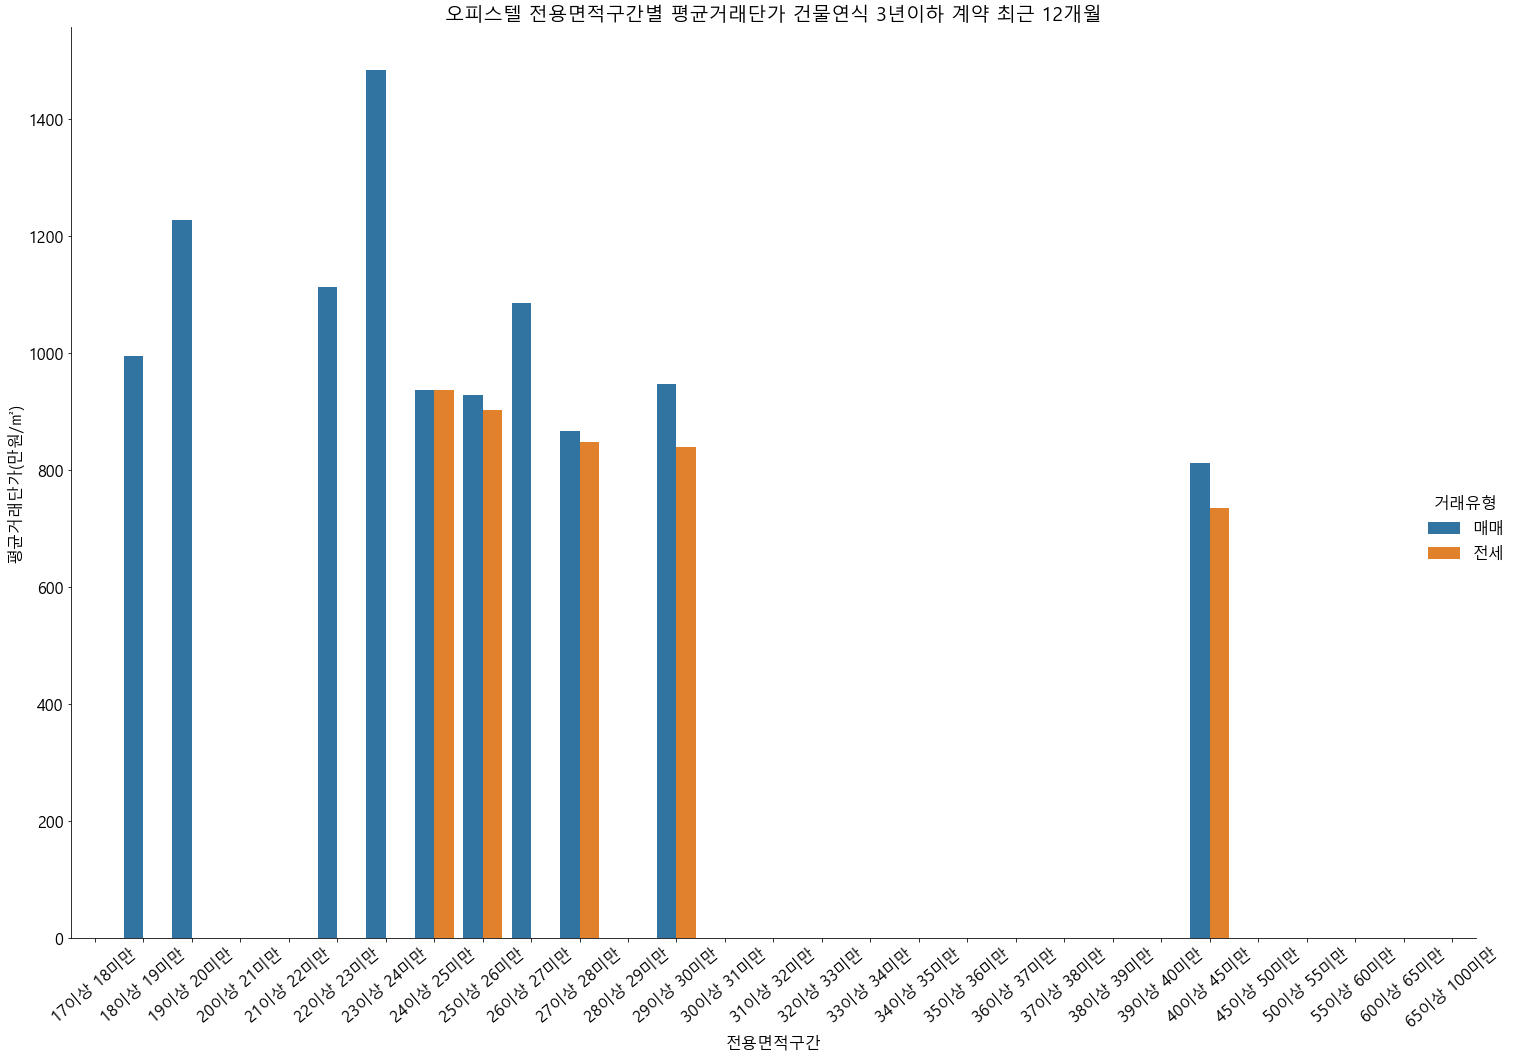

In [71]:
font = {'size': 16}
matplotlib.rc('font', **font)
sns.factorplot(x='전용면적구간', y='평균거래단가(만원/㎡)', hue='거래유형', data=concat_df, kind='bar', size=15, aspect=4/3)
plt.xticks(rotation=40)
plt.title('오피스텔 전용면적구간별 평균거래단가 건물연식 3년이하 계약 최근 12개월')
plt.tight_layout()
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전용면적구간별_오피스텔_평균거래단가_건물연식3년_계약최근12개월.png'.format(target_gu, target_dong, date_today_record))

In [72]:
target_df = target_3_36_df.copy()

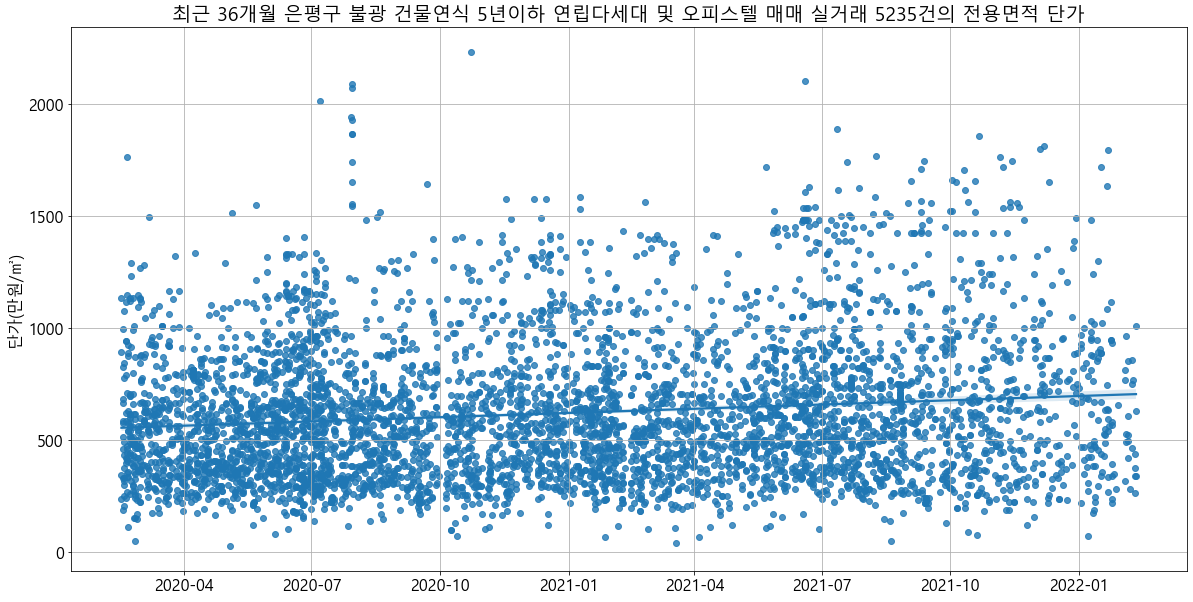

In [73]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/산포도.png'.format(target_gu, target_dong, date_today_record))

In [74]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

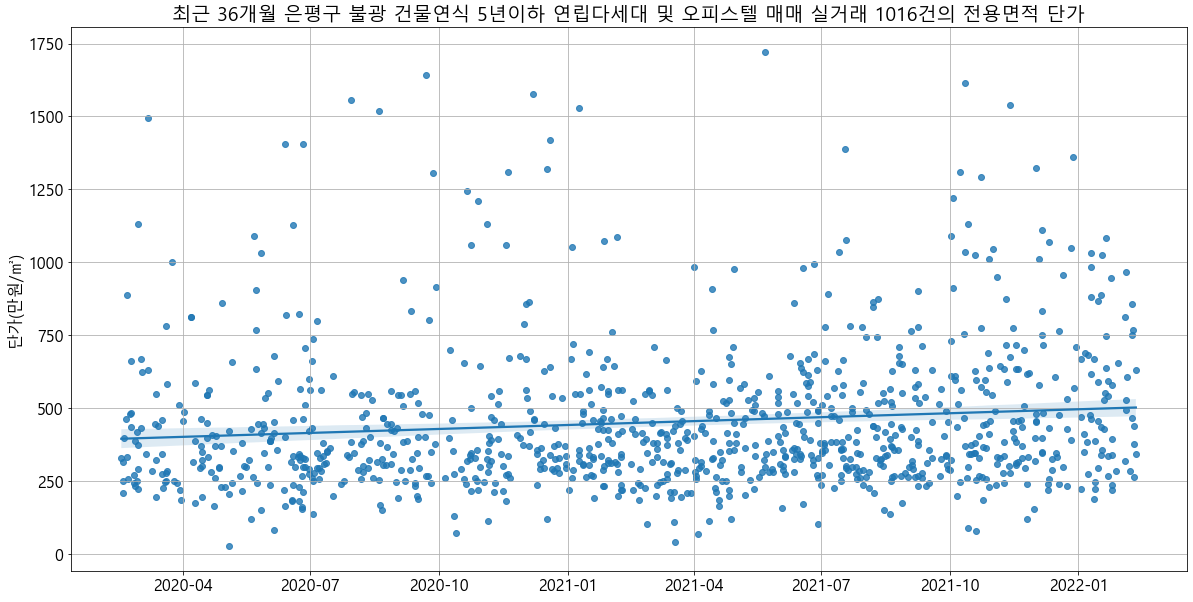

In [75]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/마지막_산포도.png'.format(target_gu, target_dong, date_today_record))

In [76]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [77]:
target_df2 = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(2928, 26)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약
1295098,서울특별시 은평구 불광동 8-53,불광로6길 11,서울특별시 은평구 불광동,8.0,53.0,제니스빌,25.02,20000,4,2016.0,NaN,NaN,전세,3.0,2019-04-13,799.360512,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N
1295099,서울특별시 은평구 불광동 8-53,불광로6길 11,서울특별시 은평구 불광동,8.0,53.0,제니스빌,44.18,24000,3,2016.0,NaN,NaN,전세,3.0,2019-05-28,543.232232,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N
1295100,서울특별시 은평구 불광동 8-53,불광로6길 11,서울특별시 은평구 불광동,8.0,53.0,제니스빌,44.18,25340,3,2016.0,-,-,매매,4.0,2020-05-23,573.562698,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N
1295101,서울특별시 은평구 불광동 8-53,불광로6길 11,서울특별시 은평구 불광동,8.0,53.0,제니스빌,44.18,24000,3,2016.0,NaN,NaN,전세,5.0,2021-06-22,543.232232,6.0,202106~202306,갱신,사용,"24,000",0.0,연립다세대,은평구,불광동,N
1295102,서울특별시 은평구 불광동 8-53,불광로6길 11,서울특별시 은평구 불광동,8.0,53.0,제니스빌,48.00,27500,4,2016.0,-,-,매매,2.0,2018-11-28,572.916667,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N


In [78]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'은평구 불광 계약날짜기준 건물연식 5년이하 연립다세대 및 오피스텔 매매 실거래 2928건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

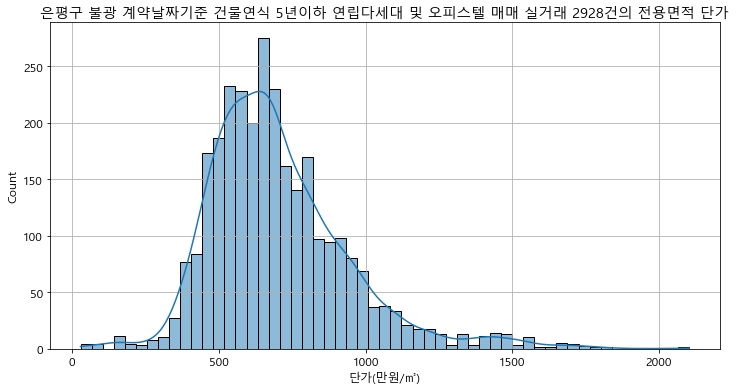

In [79]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [80]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '층', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전체_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [81]:
target_df3_30 = target_df3[
    (target_df3['전용면적(㎡)'] >= 28)
    &(target_df3['전용면적(㎡)'] <= 32)
]

In [82]:
target_df3_30.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전체_실거래가_30.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [83]:
concat_df = pd.concat([target_df2])

In [84]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [85]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [86]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '지수적용날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(834, 31)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜,단가평균,지수적용단가평균
0,서울특별시 은평구 불광동 100-14,연서로37길 43-4,서울특별시 은평구 불광동,100.0,14.0,마리빌라,29.95,13500,1,2015.0,NaN,NaN,전세,5.0,2020-02-03,450.751252,7.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N,111.519,554.495299,2021년 10월,448.654220,541.134767
1,서울특별시 은평구 불광동 100-14,연서로37길 43-4,서울특별시 은평구 불광동,100.0,14.0,마리빌라,34.71,15500,3,2015.0,NaN,NaN,전세,5.0,2020-08-21,446.557188,7.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N,116.075,527.774236,2021년 10월,448.654220,541.134767
2,서울특별시 은평구 불광동 102-15,연서로 323-5,서울특별시 은평구 불광동,102.0,15.0,신정아트빌,29.28,17850,4,2016.0,NaN,NaN,전세,4.0,2020-11-29,609.631148,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N,120.598,693.484623,2021년 10월,671.910885,744.144702
3,서울특별시 은평구 불광동 102-15,연서로 323-5,서울특별시 은평구 불광동,102.0,15.0,신정아트빌,29.70,17000,5,2016.0,NaN,NaN,전세,5.0,2021-03-19,572.390572,6.0,-,-,-,NaN,NaN,연립다세대,은평구,불광동,N,123.851,634.019694,2021년 10월,671.910885,744.144702
4,서울특별시 은평구 불광동 102-15,연서로 323-5,서울특별시 은평구 불광동,102.0,15.0,신정아트빌,43.47,35000,4,2016.0,-,-,매매,4.0,2020-09-28,805.152979,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N,118.014,935.954349,2021년 10월,671.910885,744.144702


In [87]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df.head()

(265, 31)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜,단가평균,지수적용단가평균
1,서울특별시 은평구 불광동 100-14,연서로37길 43-4,서울특별시 은평구 불광동,100.0,14.0,마리빌라,34.71,15500,3,2015.0,NaN,NaN,전세,5.0,2020-08-21,446.557188,7.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N,116.075,527.774236,2021년 10월,448.654220,541.134767
6,서울특별시 은평구 불광동 102-15,연서로 323-5,서울특별시 은평구 불광동,102.0,15.0,신정아트빌,28.61,20500,2,2016.0,NaN,NaN,전세,5.0,2021-12-07,716.532681,6.0,-,-,-,NaN,NaN,연립다세대,은평구,불광동,N,지수없음,716.532681,지수없음,671.910885,744.144702
8,서울특별시 은평구 불광동 104-10,연서로37길 22-8,서울특별시 은평구 불광동,104.0,10.0,부림베네치아,47.24,22000,3,2016.0,NaN,NaN,전세,5.0,2021-04-17,465.707028,6.0,-,-,-,NaN,NaN,연립다세대,은평구,불광동,N,125.802,507.849512,2021년 10월,561.699243,673.744874
12,서울특별시 은평구 불광동 104-18,연서로37길 24-2,서울특별시 은평구 불광동,104.0,18.0,선우에코빌,45.40,27500,2,2015.0,-,-,매매,4.0,2019-08-31,605.726872,7.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N,107.485,773.105519,2021년 10월,610.413946,751.020965
14,서울특별시 은평구 불광동 104-53,연서로37길 30-4,서울특별시 은평구 불광동,104.0,53.0,동진빌라B,47.87,26800,5,2015.0,-,-,매매,4.0,2019-07-09,559.849593,7.0,NaN,NaN,NaN,NaN,NaN,연립다세대,은평구,불광동,N,107.458,714.730650,2021년 10월,579.698552,716.242067


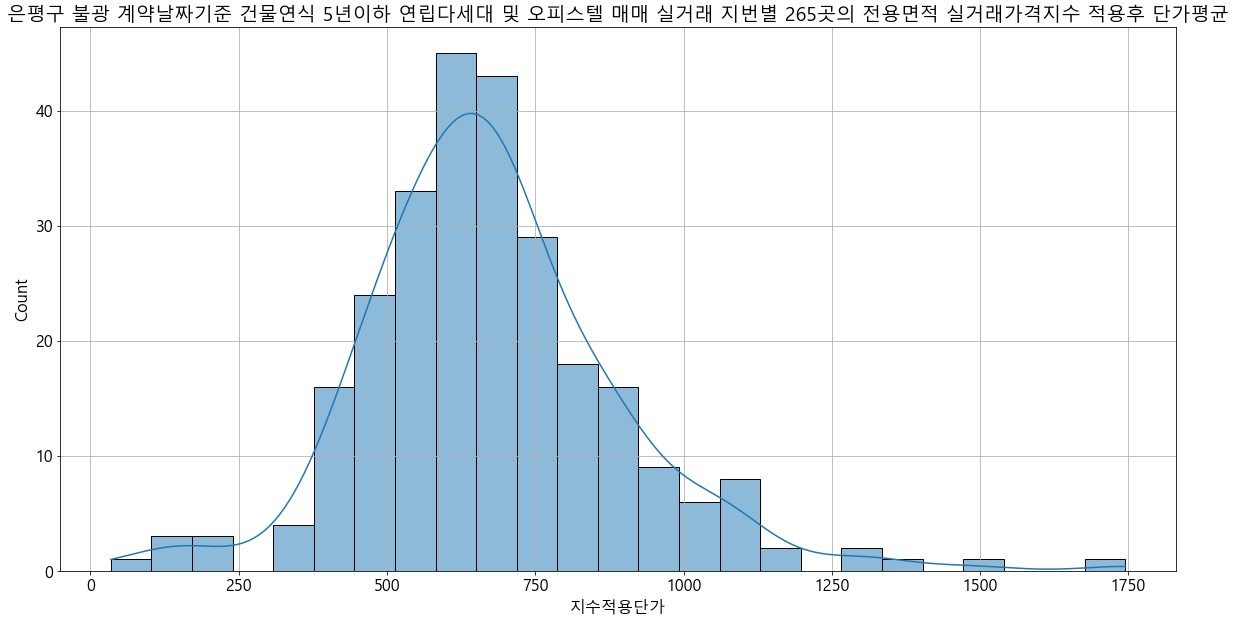

In [88]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, date_today_record))

In [89]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [90]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '층', '계약날짜', '단가(만원/㎡)', '지수적용날짜', '지수적용단가', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),층,마지막_계약날짜,단가(만원/㎡),지수적용날짜,지수적용단가,부동산유형
0,서울특별시 은평구 불광동 100-14,마리빌라,2015.0,34.71,3,2020-08-21,446.557188,2021년 10월,527.774236,연립다세대
1,서울특별시 은평구 불광동 102-15,신정아트빌,2016.0,28.61,2,2021-12-07,716.532681,지수없음,716.532681,연립다세대
2,서울특별시 은평구 불광동 104-10,부림베네치아,2016.0,47.24,3,2021-04-17,465.707028,2021년 10월,507.849512,연립다세대
3,서울특별시 은평구 불광동 104-18,선우에코빌,2015.0,45.40,2,2019-08-31,605.726872,2021년 10월,773.105519,연립다세대
4,서울특별시 은평구 불광동 104-53,동진빌라B,2015.0,47.87,5,2019-07-09,559.849593,2021년 10월,714.730650,연립다세대


In [91]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전체_마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)